In [381]:
from __future__ import print_function

In [382]:
# We'll need numpy for some mathematical operations
import numpy as np
import scipy.io.wavfile
import math
from peakdetect import *
# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline


# and IPython.display for audio output
import IPython.display


# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

In [383]:
def running_mean(x, windowSize):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[windowSize:] - cumsum[:-windowSize]) / windowSize


In [384]:
#y, sr = librosa.load("audio_knuck.wav")
sr, y = scipy.io.wavfile.read("audio_knuck.wav")
cutOffFrequency = 500.0


0.0104166666667
[[[12, -1960], [28, -1959], [49, -1953], [64, -1953], [92, -1951], [127, 2484], [171, 143], [223, -1476]], [[3, -1999], [16, -1989], [30, -1993], [61, -2023], [72, -2008], [108, -5289], [148, -5028], [191, -2967]]]


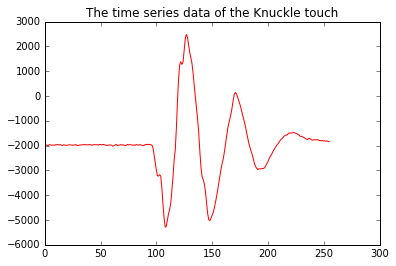

In [386]:
# Low pass filter implementation
freqRatio = (cutOffFrequency/sr)
print (freqRatio)
N = int(math.sqrt(0.196196 + freqRatio**2)/freqRatio)
peaks = peakdetect(y, lookahead=10)
print (peaks)
plt.title("The time series data of the Knuckle touch")
plt.plot(y,'r')
plt.show()
#y = running_mean(y, 5)

(32, 1)
(32, 1)


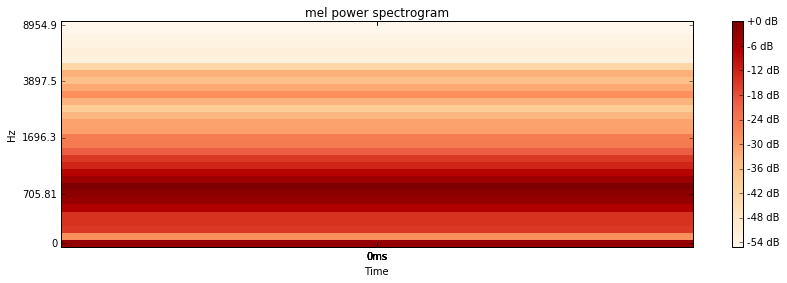

In [380]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=32)
print (S.shape)

# Convert to log scale (dB). We'll use the peak power as reference.
log_S = librosa.logamplitude(S, ref_power=np.max)
print (log_S.shape)
# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

(64, 1)
(64, 1)
(64, 1)


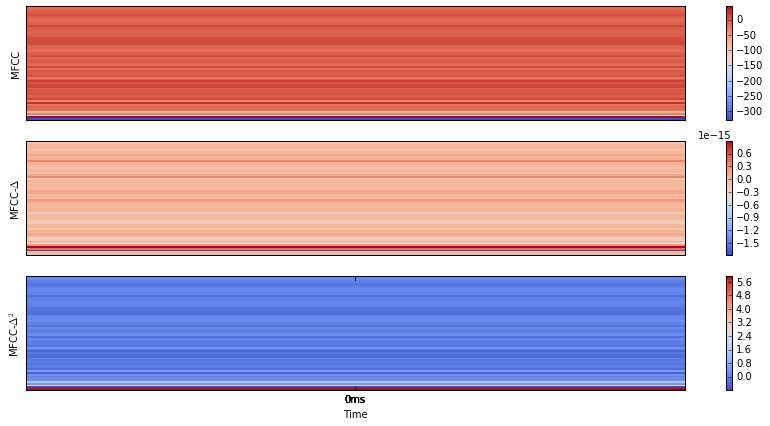

In [349]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=64)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)


print (mfcc.shape)
print (delta_mfcc.shape)
print (delta2_mfcc.shape)
# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

In [350]:
stft = librosa.stft(y)

In [351]:
Spectogram, phase = librosa.magphase(stft)

In [352]:
print (stft)

[[-10.17223644 -0.00000000e+00j]
 [  4.93426609 +3.56254956e-13j]
 [ -0.39071959 +2.25771496e-13j]
 ..., 
 [ -0.07190458 +8.55610613e-14j]
 [ -0.68725866 -5.23366073e-15j]
 [  1.30853379 -0.00000000e+00j]]


In [353]:
from scipy.signal import blackmanharris, fftconvolve

In [354]:
#from scikits.audiolab import flacread
from numpy.fft import rfft, irfft
from numpy import argmax, sqrt, mean, diff, log
from matplotlib.mlab import find
from scipy.signal import blackmanharris, fftconvolve

In [355]:
def parabolic(f, x):
    """Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.
   
    f is a vector and x is an index for that vector.
   
    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.
   
    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.
   
    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]
   
    In [4]: parabolic(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)
   
    """
    # Requires real division.  Insert float() somewhere to force it?
    xv = 1/2 * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4 * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

In [356]:
def freq_from_fft(sig, fs):
    """Estimate frequency from peak of FFT
    
    Pros: Accurate, usually even more so than zero crossing counter 
    (1000.000004 Hz for 1000 Hz, for instance).  Due to parabolic interpolation 
    being a very good fit for windowed log FFT peaks?
    https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
    Accuracy also increases with signal length
    
    Cons: Doesn't find the right value if harmonics are stronger than 
    fundamental, which is common.
    
    """
    # Compute Fourier transform of windowed signal
    windowed = sig * blackmanharris(len(sig))
    f = rfft(windowed)
    
    # Find the peak and interpolate to get a more accurate peak
    i = argmax(abs(f)) # Just use this for less-accurate, naive version
    true_i = parabolic(log(abs(f)), i)[0]
    
    # Convert to equivalent frequency
    return fs * true_i / len(windowed)

In [357]:
funda = freq_from_fft(y , sr)

In [358]:
print (funda)

1142.85714286


In [359]:
# Read in a WAV and find the freq's
import pyaudio
import wave
import numpy as np
 
chunk = 256
 
# open up a wave
wf = wave.open("audio_knuck.wav", 'rb')
swidth = wf.getsampwidth()
print (swidth)
RATE = wf.getframerate()
print (RATE)
# use a Blackman window
window = np.blackman(chunk)
# open stream
p = pyaudio.PyAudio()
stream = p.open(format =
                p.get_format_from_width(wf.getsampwidth()),
                channels = wf.getnchannels(),
                rate = RATE,
                output = True)
 
# read some data
print ("Coming here")
data = wf.readframes(chunk)
# play stream and find the frequency of each chunk
while len(data) == chunk*swidth:
    print ("Coming here")
    # write data out to the audio stream
    stream.write(data)
    # unpack the data and times by the hamming window
    indata = np.array(wave.struct.unpack("%dh"%(len(data)/swidth),\
                                         data))*window
    # Take the fft and square each value
    fftData=abs(np.fft.rfft(indata))**2
    # find the maximum
    which = fftData[1:].argmax() + 1
    # use quadratic interpolation around the max
    if which != len(fftData)-1:
        y0,y1,y2 = np.log(fftData[which-1:which+2:])
        x1 = (y2 - y0) * .5 / (2 * y1 - y2 - y0)
        # find the frequency and output it
        thefreq = (which+x1)*RATE/chunk
        print (thefreq)
        #print ("The freq is %d Hz.") % (thefreq)
    else:
        thefreq = which*RATE/chunk
        print (thefreq)
        #print ("The freq is %d Hz.") % (thefreq)
    # read some more data
    data = wf.readframes(chunk)
if data:
    stream.write(data)
stream.close()
p.terminate()

2
48000
Coming here
Coming here
49.1540163148


In [360]:
#if_gram, D = librosa.ifgram(y)
#centroid = librosa.feature.spectral_centroid(S=np.abs(D), freq=if_gram)
S, phase = librosa.magphase(librosa.stft(y=y))
centroid = librosa.feature.spectral_centroid(S=S)

roll_off = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.50)

In [361]:
print (centroid)
print (roll_off)

[[ 2060.60686846]]
[[ 3726.5625]]


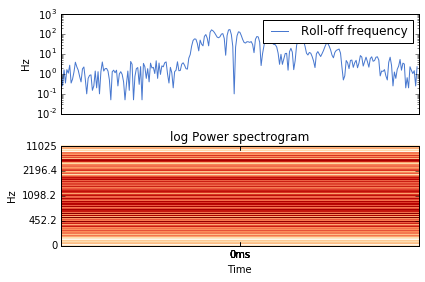

In [362]:
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(abs(y), label='Roll-off frequency')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, y.shape[-1]])
plt.legend()
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.logamplitude(S**2, ref_power=np.max),
                          y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()

[[ -2.95871274e-02]
 [  5.22463589e+02]]
(3, 1)


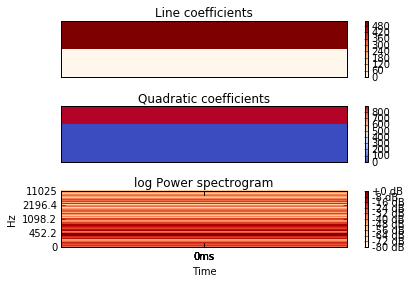

In [309]:
S = np.abs(librosa.stft(y))
line = librosa.feature.poly_features(S=S, sr=sr)
quad = librosa.feature.poly_features(S=S, order=2)

print (line)
print (quad.shape)


plt.figure()
plt.subplot(3, 1, 1)
librosa.display.specshow(line)
plt.colorbar()
plt.title('Line coefficients')
plt.subplot(3, 1, 2)
librosa.display.specshow(quad)
plt.colorbar()
plt.title('Quadratic coefficients')
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.logamplitude(S**2, ref_power=np.max),
                          y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
